In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
my_cols=['c1','c2','c3','c4','c5','c6','c7','c8','c9']
with open('../data/sample-laser-radar-measurement-data-1.txt') as f:
    table1 = pd.read_table(f, sep='\t', header=None, names=my_cols, lineterminator='\n')

with open('../data/sample-laser-radar-measurement-data-2.txt') as f:
    table2 = pd.read_table(f, sep='\t', header=None, names=my_cols, lineterminator='\n')
    
table = pd.concat([table1,table2])


laser_df = table[table['c1']=='L']
del laser_df['c9']
del laser_df['c1']
laser_df.columns = ['x','y','timestamp','gpx','gpy','gvx','gvy']

radar_df = table[table['c1']=='R']
del radar_df['c1']
radar_df.columns = ['rho','phi','rho_dot','timestamp','gpx','gpy','gvx','gvy']

In [3]:
laser_df.head(5)

,x,y,timestamp,gpx,gpy,gvx,gvy
1,8.44818,0.251553,1.477010e+15,8.45,0.25,-3.00027,0.00000
3,8.45582,0.253997,1.477010e+15,8.45,0.25,0.00000,0.00000
5,8.23962,0.249160,1.477010e+15,8.25,0.25,-1.81978,0.00000
7,7.84073,0.159858,1.477010e+15,7.85,0.15,-3.99972,-0.99993
9,7.54016,0.159641,1.477010e+15,7.55,0.15,-2.99982,0.00000


In [4]:
radar_df.head(5)

,rho,phi,rho_dot,timestamp,gpx,gpy,gvx,gvy
0,8.46642,0.028760,-3.040350,1.477010e+15,8.60,0.25,-3.00029,0.00000
2,8.57101,0.028232,-0.010526,1.477010e+15,8.45,0.25,0.00000,0.00000
4,8.42927,0.030143,-1.858130,1.477010e+15,8.35,0.25,-1.81979,0.00000
6,7.93510,0.023744,-3.810770,1.477010e+15,8.05,0.20,-3.99976,-0.99994
8,7.61428,0.020465,-3.220520,1.477010e+15,7.70,0.15,-2.99982,0.00000


### Extract the x, y data and the corresponding ground truth data

In [5]:
xdata=np.array(laser_df['x'].values)
gpxdata=np.array(laser_df['gpx'].values)
vxdata=gpxdata-xdata
ydata=np.array(laser_df['y'].values)
gpydata=np.array(laser_df['gpy'].values)
vydata=gpydata-ydata

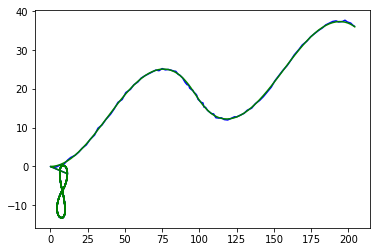

In [6]:
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(gpxdata, gpydata, 'g-', label='gt')

### Have a look at the difference between the x, y and ground truth x y

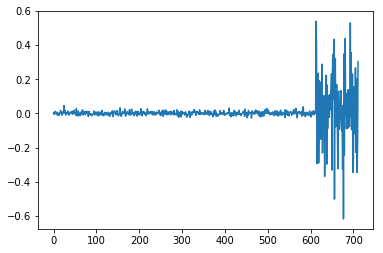

In [7]:
plt.plot(vxdata)

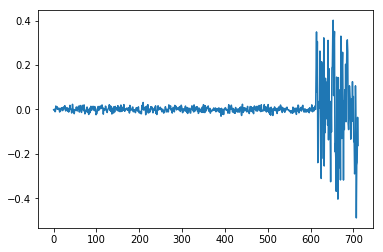

In [8]:
plt.plot(vydata)

### Variance in the differences (laser data)

In [9]:
np.var(vxdata), np.var(vydata)

(0.0068374897772981421, 0.0054887300686829819)

### Variance in the differences (radar data) - converted between cartesian/polar

In [10]:
def calc_hx(gpx,gpy,gvx,gvy):
    if gpx == 0:
        return 0,0,0
    rho = math.sqrt(gpx*gpx + gpy*gpy)
    phi = math.atan(gpy/gpx)
    rho_dot = (gpx*gvx + gpy*gvy)/rho
    return np.array([rho,phi,rho_dot])

In [11]:
ghs=[ np.hstack([z[0], z[1], z[2], calc_hx(z[3], z[4], z[5], z[6])]) for z in radar_df.as_matrix(['rho', 'phi', 'rho_dot', 'gpx', 'gpy', 'gvx', 'gvy'])]

gr_df = pd.DataFrame(ghs)
gr_df.columns = ['rho', 'phi', 'rho_dot', 'grho', 'gphi', 'grho_dot']
vrhodata=np.array(gr_df['grho'].values -gr_df['rho'].values)
vphidata=np.array(gr_df['gphi'].values -gr_df['phi'].values)
vrhodotdata=np.array(gr_df['grho_dot'].values -gr_df['rho_dot'].values)
#gr_df

In [12]:
np.var(vrhodata), np.var(vphidata), np.var(vrhodotdata)

(0.014412589090776581, 1.3610836622321855e-06, 0.011073356944289297)

In [15]:
cov_table = table.copy()
cov_table.reindex()
del cov_table['c7']
del cov_table['c8']
del cov_table['c9']
#cov_table.columns = ['px','py','v','gpx','gpy','gvx','gvy']
cov_table.cov()

,c2,c3,c4,c5,c6
c2,1.534711e+03,1.904515e+02,-1.108100e+15,1.108101e+15,9.668266e+02
c3,1.904515e+02,5.851682e+01,-8.873367e+14,8.873367e+14,7.638459e+01
c4,-1.108100e+15,-8.873367e+14,5.457733e+29,-5.457733e+29,-8.940277e+15
c5,1.108101e+15,8.873367e+14,-5.457733e+29,5.457733e+29,8.940277e+15
c6,9.668266e+02,7.638459e+01,-8.940277e+15,8.940277e+15,9.733637e+02
